<a href="https://colab.research.google.com/github/YTW0415/Kaggle_Basketball/blob/main/Kaggle_basket_20230301.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github 연동 관련 주소

https://heytech.tistory.com/393

In [6]:
!mkdir Test

mkdir: cannot create directory ‘Test’: File exists


In [7]:
cd /content/Test/

/content/Test


In [8]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

Cloning into 'Kaggle_Basketball'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 54 (delta 6), reused 33 (delta 1), pack-reused 0
Unpacking objects: 100% (54/54), 28.03 MiB | 3.49 MiB/s, done.
Updating files: 100% (35/35), done.


In [9]:
cd Kaggle_Basketball

/content/Test/Kaggle_Basketball


In [13]:
!git config --global user.name 'YTW0415'
!git config --global user.email 'ytaewon0415@gmail.com'

In [14]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [16]:
!git add qds.txt
!git commit -m "Connect Google Colab and Drive"

[main 8cfcb01] Connect Google Colab and Drive
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 qds.txt


In [17]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


### Base line 2021 2nd place

# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [3]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [4]:
df_seeds['Seed'].value_counts()

W01     61
X14     61
Y01     61
Y02     61
Y03     61
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [5]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [6]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [7]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [8]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [9]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [10]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [11]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [12]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [13]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [14]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [15]:
df_features_season.fillna(0, inplace=True)  

In [16]:
df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses
0,1985,1102,5.0,19.0,10.000000,9.947368
1,1985,1103,9.0,14.0,7.555556,9.857143
2,1985,1104,21.0,9.0,13.190476,4.777778
3,1985,1106,10.0,14.0,9.500000,13.285714
4,1985,1108,19.0,6.0,13.842105,10.666667
...,...,...,...,...,...,...
21423,2023,3473,1.0,22.0,9.000000,19.318182
21424,2023,3474,5.0,18.0,10.200000,19.888889
21425,2023,3475,8.0,16.0,13.875000,11.625000
21426,2023,3476,7.0,19.0,10.571429,13.368421


Compute features

In [17]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [18]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [19]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [20]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [21]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

# Feature Engineering

## Train data

In [22]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [23]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [24]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [25]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [26]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [27]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,12,5
1,2016,137,3113,74,3308,52,2,15
2,2016,137,3120,68,3385,57,9,8
3,2016,137,3124,89,3225,59,1,16
4,2016,137,3177,97,3241,67,6,11


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [28]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [29]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [30]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250


### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [31]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [32]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [33]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [34]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [35]:
df = add_loosing_matches(df)

In [36]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250
...,...,...,...,...,...,...,...,...,...,...,...,...
778,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176
779,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879
780,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176
781,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [37]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

## Test Data

### Preparing

In [38]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [39]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [40]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [41]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [42]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [43]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [44]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [45]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [46]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [47]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [48]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [49]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [50]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [51]:
# features = [
#     'SeedDiff',
# #     '538ratingDiff',
#     'WinRatioDiff', 
#     'GapAvgDiff', 
# ]

In [52]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [53]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [54]:
pred_tests = kfold(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2017
	 -> Scored 0.164

Validating on season 2018
	 -> Scored 0.188

Validating on season 2019
	 -> Scored 0.154

Validating on season 2021
	 -> Scored 0.190

Validating on season 2022
	 -> Scored 0.197

 Local CV is 0.179


In [55]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,7,0.137634,9.977419,2,1
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,-13,-0.050691,0.293779,22,1
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,1,-0.105847,-3.780242,11,1
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,-15,0.260911,14.004744,30,1
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,-5,-0.086174,0.866477,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,9,-0.126560,-6.653298,-26,0
779,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,7,-0.106583,-1.856844,-20,0
780,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,1,-0.035651,-0.895722,-16,0
781,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,-6,0.096257,7.241533,-4,0



Validating on season 2017


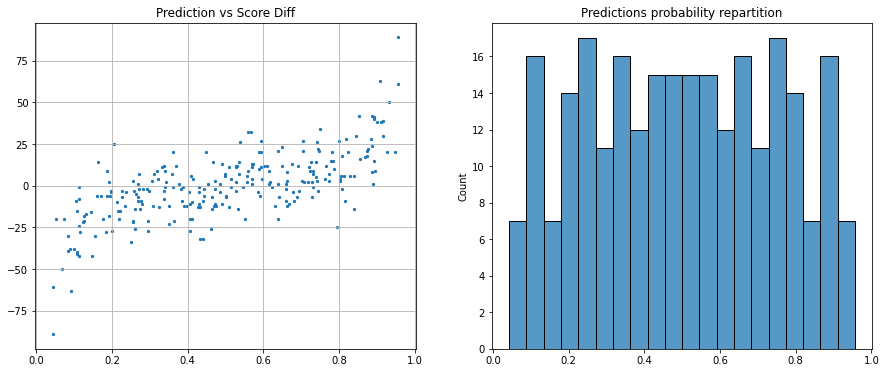

	 -> Scored 0.164

Validating on season 2018


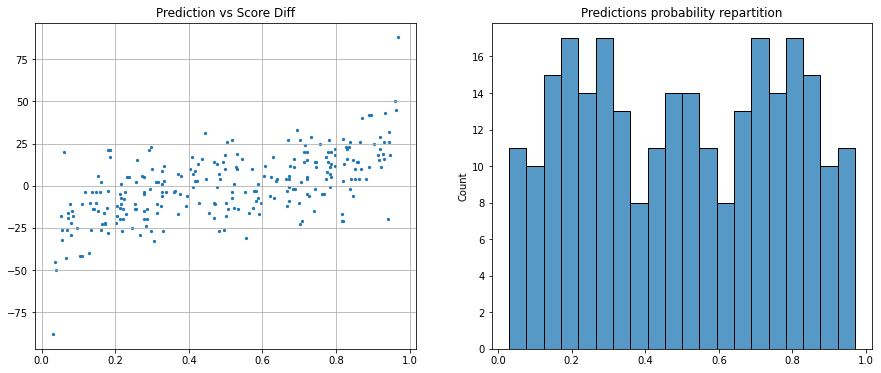

	 -> Scored 0.188

Validating on season 2019


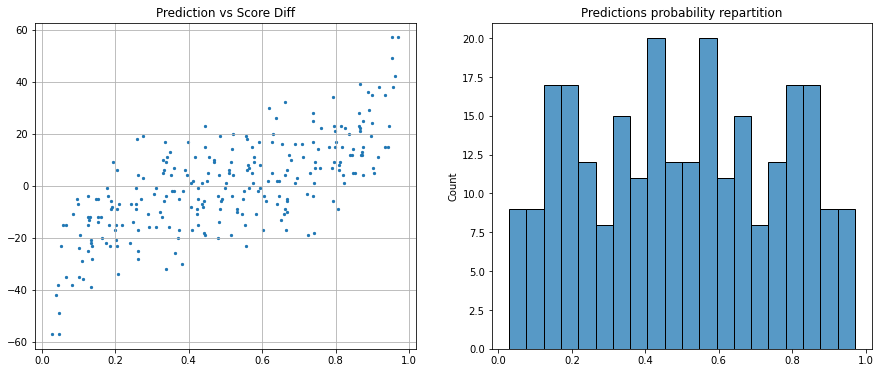

	 -> Scored 0.154

Validating on season 2021


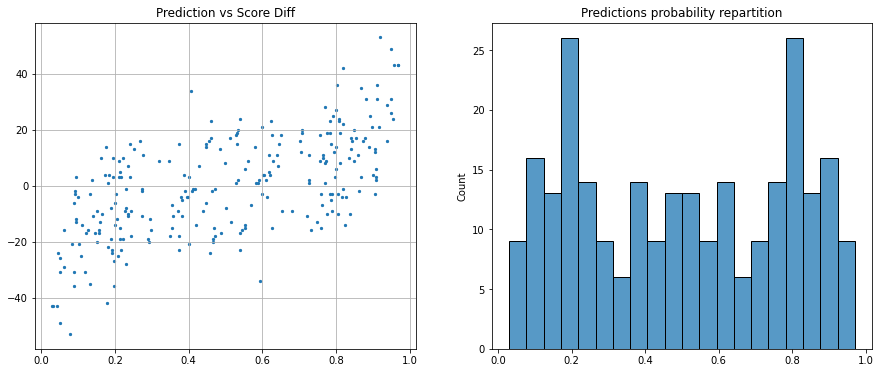

	 -> Scored 0.190

Validating on season 2022


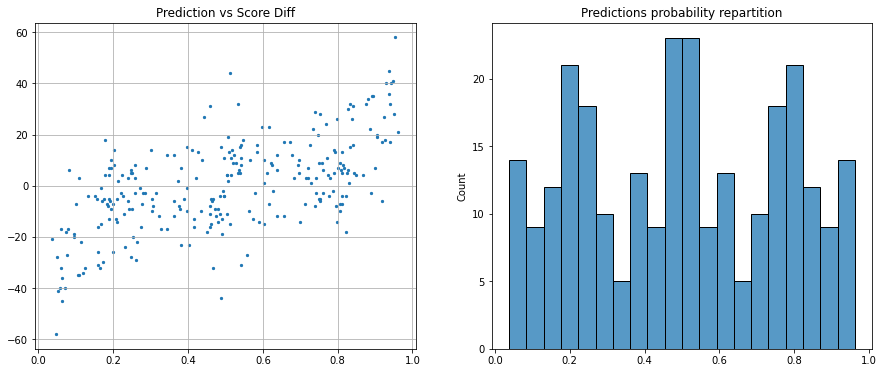

	 -> Scored 0.197

 Local CV is 0.179


In [56]:
plot=True
verbose=1
mode="cls"
df_test_ = df_test

seasons = df['Season'].unique()
cvs = []
pred_tests = []
target = "ScoreDiff" if mode == "reg" else "WinA"

for season in seasons[1:]:
    if verbose:
        print(f'\nValidating on season {season}')
    
    df_train = df[df['Season'] < season].reset_index(drop=True).copy()
    df_val = df[df['Season'] == season].reset_index(drop=True).copy()
    df_test = df_test_.copy()
    
    df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
    
    if mode == "reg":
#             model = LinearRegression()
        model = ElasticNet(alpha=1, l1_ratio=0.5)
    else:
        model = LogisticRegression(C=1)

    model.fit(df_train[features], df_train[target])
    
    if mode == "reg":
        pred = model.predict(df_val[features])
    else:
        pred = model.predict_proba(df_val[features])[:, 1]
    
    if df_test is not None:
        if mode == "reg":
            pred_test = model.predict(df_test[features])
            
#                 print( pred_test.max() - pred_test.min())
            pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
        else:
            pred_test = model.predict_proba(df_test[features])[:, 1]
            
        pred_tests.append(pred_test)
        
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
        plt.title('Prediction vs Score Diff')
        plt.grid(True)
        plt.subplot(1, 2, 2)
        sns.histplot(pred, bins=20)
        plt.title('Predictions probability repartition')
        plt.show()
    
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    pred = np.clip(pred, 0, 1)

    score = ((df_val['WinA'].values - pred) ** 2).mean()
    
    cvs.append(score)

    if verbose:
        print(f'\t -> Scored {score:.3f}')
    
print(f'\n Local CV is {np.mean(cvs):.3f}')

## Submission

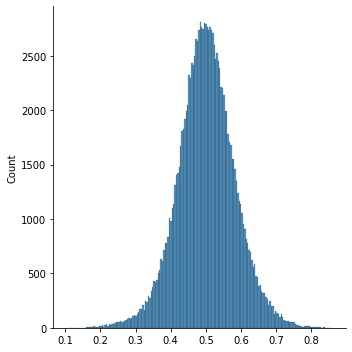

In [57]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [59]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [60]:
final_sub

,ID,pred
0,2023_1101_1102,0.477936
1,2023_1101_1103,0.449092
2,2023_1101_1104,0.378438
3,2023_1101_1105,0.497743
4,2023_1101_1106,0.551261
...,...,...
130678,2023_3474_3476,0.432406
130679,2023_3474_3477,0.442591
130680,2023_3475_3476,0.532760
130681,2023_3475_3477,0.543008


Done ! 

# AutoML

In [159]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 K

In [169]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.1.1 requires packaging<23, but you have packaging 23.0 which is incompatible.
explainerdashboard 0.4.2.1 requires graphviz>=0.18.2, but you have graphviz 0.10.1 which is incompatible.
explainerdashboard 0.4.2.1 requires scikit-learn>=1.1, but 

In [170]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=069b7034fc31d1978159c4550e5fb584409314c1de17cdbf0a03e59445b575b2
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.

In [61]:
train_df = pd.concat([df[features], df['WinA']],axis=1)

In [62]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

reg_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=5,
                   normalize = True,
                   transformation = True,
                   pca = False,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )


,Description,Value
0,session_id,1541
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1566, 10)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  random_state_quantile=1541,
                                                  target='WinA')),
                ('binn', 'pas

In [64]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function                   <function log_loss at 0x7f2619289e50>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [65]:
#svm, ridge는 predict_proba 미지원으로 제외
best3 = compare_models(fold = 3, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
lr,Logistic Regression,0.7226,0.8175,0.7256,0.7262,0.7251,0.4452,0.4461,0.5126,3.5533
lda,Linear Discriminant Analysis,0.7154,0.8123,0.7202,0.7181,0.7182,0.4306,0.4318,0.5267,0.0333
catboost,CatBoost Classifier,0.7053,0.8024,0.7075,0.7080,0.7072,0.4105,0.4112,0.5364,4.6067
gbc,Gradient Boosting Classifier,0.7026,0.7959,0.7112,0.7032,0.7070,0.4050,0.4052,0.5490,0.2400
rf,Random Forest Classifier,0.6925,0.7846,0.6895,0.6977,0.6933,0.3851,0.3854,0.5838,0.5300
ada,Ada Boost Classifier,0.6870,0.7695,0.6948,0.6887,0.6910,0.3739,0.3748,0.6583,0.1500
lightgbm,Light Gradient Boosting Machine,0.6898,0.7685,0.7129,0.6856,0.6985,0.3792,0.3802,0.6925,0.3567
dummy,Dummy Classifier,0.5055,0.5000,1.0000,0.5055,0.6715,0.0000,0.0000,0.6931,0.0333
et,Extra Trees Classifier,0.6679,0.7629,0.6787,0.6691,0.6735,0.3356,0.3360,0.7248,0.2967
xgboost,Extreme Gradient Boosting,0.6770,0.7669,0.6912,0.6761,0.6831,0.3538,0.3544,0.7457,0.2833


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 3
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1541, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), <catboost.core.CatBoostClassifier object at 0x7f25e97017c0>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_le

In [67]:
#lda 와 nb는 losloss가 좋지만 accuracy, auc가 상대적으로 좋지 않아 커스텀모델 생성

custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 3, include=['lr','lda','catboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
lr,Logistic Regression,0.7235,0.8160,0.7110,0.7337,0.7207,0.4472,0.449,0.5146,0.050
lda,Linear Discriminant Analysis,0.7153,0.8094,0.7146,0.7200,0.7161,0.4306,0.432,0.5300,0.032
catboost,CatBoost Classifier,0.6989,0.7982,0.7020,0.7012,0.7012,0.3977,0.398,0.5417,4.108


INFO:logs:create_model_container: 49
INFO:logs:master_model_container: 49
INFO:logs:display_container: 5
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1541, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), <catboost.core.CatBoostClassifier object at 0x7f25e428a9a0>]
INFO:logs:compare_models() succesfully completed......................................


In [68]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
Fold,,,,,,,,
0,0.7045,0.8084,0.7568,0.6885,0.7210,0.4085,0.4106,0.5243
1,0.6575,0.7560,0.6273,0.6699,0.6479,0.3153,0.3159,0.5821
2,0.7215,0.8296,0.6847,0.7451,0.7136,0.4434,0.4449,0.4912
3,0.7626,0.8489,0.8108,0.7438,0.7759,0.5244,0.5266,0.4726
4,0.7169,0.8116,0.7117,0.7248,0.7182,0.4338,0.4339,0.5299
Mean,0.7126,0.8109,0.7182,0.7144,0.7153,0.4251,0.4264,0.5200
Std,0.0337,0.0310,0.0624,0.0302,0.0406,0.0673,0.0677,0.0376


INFO:logs:create_model_container: 50
INFO:logs:master_model_container: 50
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1541,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,Voting Classifier,0.717,0.8049,0.6812,0.7222,0.7011,0.4329,0.4335,0.5393


In [70]:
#Accurary, AUC, Logloss 셋다 상위 4개인 모델 
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1541,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [71]:
#Accurary, AUC, Logloss 셋다 상위 4개인 모델 사용
prep_pipe = get_config("prep_pipe")
prep_pipe.steps.append(['trained_model', final_model_custom])
prections = prep_pipe.predict_proba(df_test)
prections

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  random_state_quantile=1541,
                                                  target='WinA')),
                

array([[0.77913387, 0.22086614],
       [0.72728139, 0.2727186 ],
       [0.58480777, 0.41519223],
       ...,
       [0.81605741, 0.18394258],
       [0.7731879 , 0.2268121 ],
       [0.75057625, 0.24942375]])

In [74]:
i, j = [], []
for row in prections:
  i.append(row[0])
  j.append(row[1])

len(i), len(j)

(130683, 130683)

In [78]:
pd.DataFrame(i)

,0
0,0.779134
1,0.727281
2,0.584808
3,0.812983
4,0.832518
...,...
130678,0.787157
130679,0.737094
130680,0.816057
130681,0.773188


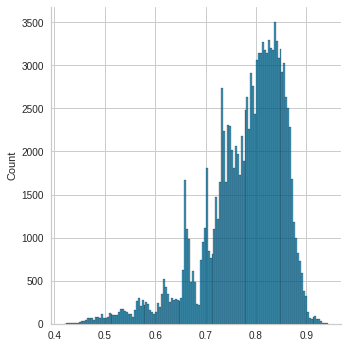

In [80]:
df_test_after_AutoML = df_test.copy()

df_test['pred'] = i

_ = sns.displot(i)

In [81]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'pred']].copy()

final_sub_after_AutoML.to_csv('submission.csv', index=False)